In [2]:
# Data handling and analysis libraries
import pandas as pd
import numpy as np

# Data base
import sqlite3
import requests
import urllib

# Geographic libraries
from osgeo import gdal
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points
import geopandas as gpd
import gdal
import fiona

# Visualization
import folium
from folium import plugins
from folium.plugins import HeatMap
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from time import sleep
import time

# Organizing data and Build DataBase

1. Connecting to sql wildfire database
2. creating a pandas df
3. Reducing the dataset:
    - Finding the number of wildfires in every state
    - Choosing one state for the case study


* One-time execution of that part,
 no need to run again after getting CSV file of the organized data

### Data sources
Wildfires - https://www.kaggle.com/rtatman/188-million-us-wildfires
Weather - https://www.kaggle.com/selfishgene/historical-hourly-weather-data
DEM - SRTM

In [3]:
# Connect to Wildfire database file
con = sqlite3.connect(r'data\FPA_FOD_20170508.sqlite')

In [4]:
# Read to DataFrame
df = pd.read_sql_query('SELECT * FROM Fires;',con)
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [5]:
# Heat map according to FIRE_SIZE
map_ = folium.Map(location=[df["LATITUDE"].mean(), df["LONGITUDE"].mean()],
                    tiles = "Stamen Terrain",
                    zoom_start = 3)


heat_df = df[["LATITUDE","LONGITUDE", "FIRE_YEAR", "FIRE_SIZE"]]
# limit number of points, to get a processible result
heat_df = heat_df[heat_df["FIRE_SIZE"] > 1800]
heat_df = heat_df.dropna(axis=0, subset=["LATITUDE","LONGITUDE"])

# List comprehension to make out list of lists
heat_data = [[row["LATITUDE"],row["LONGITUDE"]] for index, row in heat_df.iterrows()]
del heat_df

# Plot it on the map
HeatMap(heat_data, min_opacity=.4, max_val=.8).add_to(map_)

# Display the map
map_


Reduce Database

STATE
AK     12843
AL     66570
AR     31663
AZ     71586
CA    189550
CO     34157
CT      4976
DC        66
DE       171
FL     90261
GA    168867
HI      9895
IA      4134
ID     36698
IL      2327
IN      2098
KS      7673
KY     27089
LA     30013
MA      2626
MD      3622
ME     13150
MI     10502
MN     44769
MO     17953
MS     79230
MT     40767
NC    111277
ND     15201
NE      7973
NH      2452
NJ     25949
NM     37478
NV     16956
NY     80870
OH      3479
OK     43239
OR     61088
PA      8712
PR     22081
RI       480
SC     81315
SD     30963
TN     31154
TX    142021
UT     30725
VA     21833
VT       456
WA     33513
WI     31861
WV     21967
WY     14166
dtype: int64


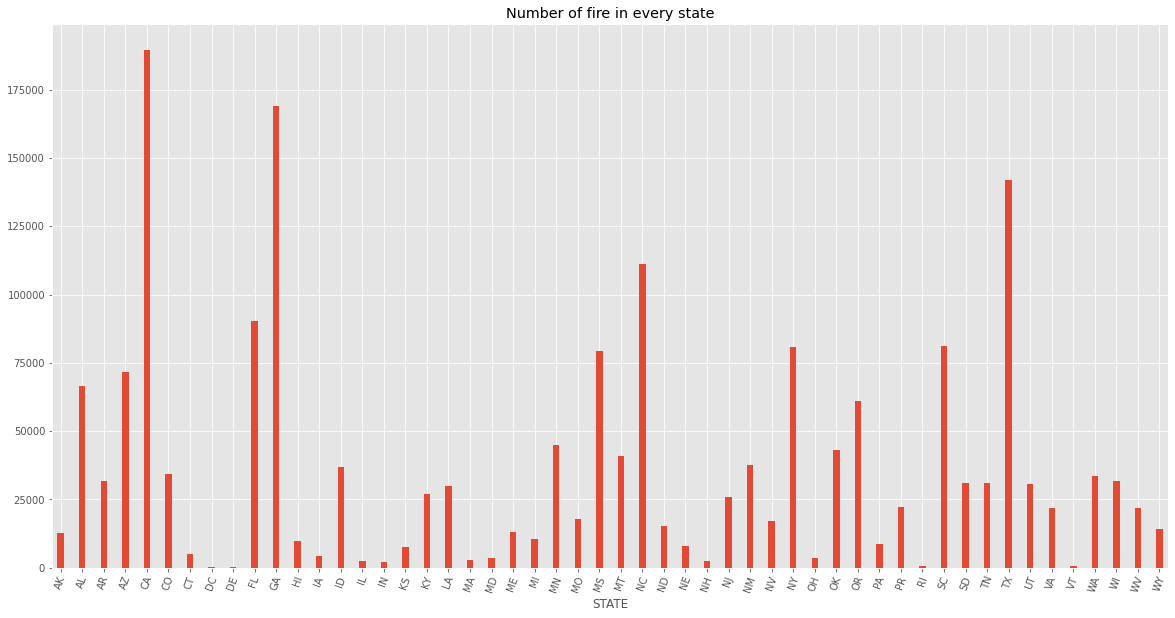

In [6]:
# Check the distribution of fires between the states
fire_state = df.pivot_table(index=['STATE'],aggfunc='size')
print(fire_state)
plt.figure(figsize=(20, 10))
fire_state.plot.bar(rot=70 ,align='center', width=0.3 ,title="Number of fire in every state")
plt.show()

We decided to focus on California which has the maximum number of fires

In [ ]:
CA_df = df.loc[df['STATE'] == 'CA']
CA_df.to_csv(r'results\California_fires.csv')


In [7]:
# Close sql connection
con.close()

# Case study California wildfires

In [8]:
# read CSV
# CA_fires = pd.read_csv(r'data\California_fires_25.csv')
CA_fires = pd.read_csv(r'results\California_fires.csv')

In [9]:
# create GeoDataFrame
locations = gpd.points_from_xy(x=CA_fires.LONGITUDE, y=CA_fires.LATITUDE)
CA_fires['geometry'] = locations
CA_fires.head()
geo_fires = gpd.GeoDataFrame(CA_fires, geometry='geometry', crs="EPSG:4326")

California Heat map

In [12]:
map_CA = folium.Map(location=[geo_fires["LATITUDE"].mean(), geo_fires["LONGITUDE"].mean()],
                    tiles = "Stamen Terrain",
                    zoom_start = 6)


heat_df2 = geo_fires[["LATITUDE","LONGITUDE", "FIRE_YEAR", "FIRE_SIZE"]]
# limit number of points, to get a processible result
heat_df2 = heat_df2[heat_df2["FIRE_SIZE"] > 1800]
heat_df2 = heat_df2.dropna(axis=0, subset=["LATITUDE","LONGITUDE"])

# List comprehension to make out list of lists
heat_data2 = [[row["LATITUDE"],row["LONGITUDE"]] for index, row in heat_df2.iterrows()]
del heat_df2

# Plot it on the map
HeatMap(heat_data2, min_opacity=.4, max_val=.8).add_to(map_CA)

# Display the map
map_CA

The wildfires dataset cover the years 1992-2015,
while the weather dataset begins in Oct' 2012 and ends in 2017.
So we got an overlap between Oct' 2012 to the end of 2015.

Also we decided to reduce the prediction area between LAT 32 to 35.

In [ ]:
geo_fires_small = geo_fires.loc[(geo_fires['LATITUDE'] >= 32) & (geo_fires['LATITUDE'] <= 35)
                                & (geo_fires['FIRE_YEAR'] >= 2012) & (geo_fires['FIRE_YEAR'] <= 2015)]

In [ ]:
# save to shapefile
geo_fires_small.to_file(r'results\shp\fires_2012-15.shp')

# Create cells
We created the cells in QGIS by splitting SRTM tiles to 10X10 cells and converting to polygons.
Every tile is 1$^\circ$ X 1$^\circ$ which is about 100X100 km,
so every cell is about 10X10 km.

In [ ]:
# load cells polygons
geo_cells = gpd.read_file(r'data\cells_polygons_california_only.shp',crs="EPSG:4326")
geo_cells.head()

geo_cells = geo_cells.drop(columns=['path','layer'])
geo_cells.head()

In [ ]:
# load fires data
fires = gpd.read_file(r'results\shp\fires_2012-15.shp',crs="EPSG:4326")
fires.head()

In [ ]:
# calculate topographic statistics for each cell
for i, cell in geo_cells.iterrows():
    path = str(cell['location'][str.find(cell['location'],'data'):])
    raster = gdal.Open(path)
    band = raster.GetRasterBand(1)
    stats = band.ComputeStatistics(0)
    geo_cells.at[i,'min_height'] = stats[0]
    geo_cells.at[i,'max_height'] = stats[1]
    geo_cells.at[i,'avg_height'] = stats[2]
    geo_cells.at[i,'std_height'] = stats[3]

geo_cells.head()

In [ ]:
# save
geo_cells.to_file(r'results\shp\geo_cells_basic.shp',crs="EPSG:4326")


# Manege weather data

We got an hourly weather datasets of about 30 cities around the world.
The relevant data is temperature, humidity, pressure and wind speed.
We found 3 cities that covers our case study area - Los Angeles, San Diego and Las Vegas.

first we are going to change the dataset to weekly basis (because we want to make weekly predictions),
then we are going to find the closest city for every cell to get the relevant values

In [ ]:
def weeklyWeather(file_path):
    """
    Get hourly weather data and return weekly data
    :param file_path: CSV file path
    :return: DataFrame of weekly weather in Los Angeles, San Diego and Las Vegas
    """

    # read csv data
    df = pd.read_csv(file_path)
    df = df[['datetime','Los Angeles', 'San Diego', 'Las Vegas']]
    # convert to date feature
    df['datetime'] = pd.to_datetime(df['datetime'])
    # extract years months and weeks from the date features
    df['year']= df['datetime'].dt.year
    df['month']= df['datetime'].dt.month
    df['week_of_year'] = df['datetime'].dt.week
    # take data only between years 2012-2015
    df = df.loc[(df['year'] >= 2012) & (df['year'] <= 2015)]
    # solve a specific case when the last days of one year counts in the 'week_of_year' of the next year
    df.loc[(df['month'] == 12) & (df['week_of_year'] == 1) , 'year'] += 1
    df.drop(columns=['month'], inplace=True )
    # calculate the average weather value of every week
    return df.groupby(['year','week_of_year'],as_index=False).mean()

In [ ]:
temperature = weeklyWeather(r'data\weather\temperature.csv')
humidity = weeklyWeather(r'data\weather\humidity.csv')
pressure = weeklyWeather(r'data\weather\pressure.csv')
wind_speed = weeklyWeather(r'data\weather\wind_speed.csv')

In [ ]:
# save CSV
temperature.to_csv(r'results\weekly_weather\temperature_weekly.csv')
humidity.to_csv(r'results\weekly_weather\humidity_weekly.csv')
pressure.to_csv(r'results\weekly_weather\pressure_weekly.csv')
wind_speed.to_csv(r'results\weekly_weather\wind_speed_weekly.csv')

In [ ]:
# read weather
temperature = pd.read_csv(r'results\weekly_weather\temperature_weekly.csv')
humidity = pd.read_csv(r'results\weekly_weather\humidity_weekly.csv')
pressure = pd.read_csv(r'results\weekly_weather\pressure_weekly.csv')
wind_speed= pd.read_csv(r'results\weekly_weather\wind_speed_weekly.csv')

Find the nearest city to every cell

In [ ]:
def nearest(row, gdf1, gdf2, geom_col1,geom_col2, src_column=None):
    """
    Find the nearest point and return the corresponding value from specified column
    :param row: row of gdf1
    :param gdf1: GeoDataFrame of points that we want to find their nearest point from gdf2
    :param gdf2: GeoDataFrame of points that we want to find the nearest point for them from gdf1
    :param geom_col1: Name of geometry column in df1
    :param geom_col2: Name of geometry column in df2
    :param src_column: Name of the column that contain the values
    :return: The values of the nearest points in new column of gdf1
    """
    geom_union = gdf2.geometry.unary_union
    # Find the geometry that is closest
    nearest_ = gdf2[geom_col2] == nearest_points(row[geom_col1], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = gdf2.loc[nearest_,src_column].to_numpy()[0]
    return value

In [ ]:
# read cities weather
df2 = pd.read_csv(r'data\cities_weather.csv')
locations_points = gpd.points_from_xy(x=df2.lon, y=df2.lat)
df2['geometry'] = locations_points

cities = gpd.GeoDataFrame(df2, geometry='geometry', crs="EPSG:4326")

In [ ]:
# read cells
geo_cells = gpd.read_file(r'results\shp\geo_cells_basic.shp',crs="EPSG:4326")

In [ ]:
# find centroid of every cell's polygon
# projection to epsg=3310
proj_cells = geo_cells.to_crs(epsg=3310)
# calc centroids
proj_cells['centroid'] = proj_cells.centroid
# projection back to epsg=4326 (geographic)
centroid_4326 = proj_cells.centroid.to_crs(epsg=4326)
geo_cells['centroid'] = centroid_4326


In [ ]:
# find cells's nearest city
geo_cells['nearest city'] = geo_cells.apply(nearest, gdf1=geo_cells,
                                                        gdf2=cities, geom_col1='centroid',geom_col2='geometry' , src_column='city', axis=1)

In [ ]:
# Check the number of closed points fot every city
closed_cities = geo_cells.pivot_table(index=['nearest city'], aggfunc='size')
closed_cities

In [ ]:
# saving to shapefile
# remove the centroid column to stay with only one geometric column
geo_cells.drop('centroid', axis=1, inplace=True)
# save
geo_cells.to_file(r'results\shp\geo_cells_with_cities.shp')

# create cell for every week in every year

In [ ]:
# read
fires = gpd.read_file(r'results\shp\fires_2012-15.shp',crs="EPSG:4326")
geo_cells = gpd.read_file(r'results\shp\geo_cells_with_cities.shp')

In [ ]:
geo_cells_with_weeks = geo_cells.copy()
geo_cells_with_weeks['week'] = 39
geo_cells_with_weeks['year'] = 2012

In [ ]:
# for 2012

for i in range(40,52):
    gd = geo_cells.copy()
    gd['week'] = i
    gd['year'] = 2012
    geo_cells_with_weeks = geo_cells_with_weeks.append(gd)

In [ ]:
# for 2013-2015

for j in range (2013,2016):
    for i in range(0,52):
        gd = geo_cells.copy()
        gd['week'] = i
        gd['year'] = j
        geo_cells_with_weeks = geo_cells_with_weeks.append(gd)

geo_cells_with_weeks.reset_index(drop=True, inplace=True)

In [ ]:
# fitting fires to cells in year 2012
for i in range(39,52):
    temp_fires = fires[fires['FIRE_YEAR']==2012]
    temp_fires = temp_fires[fires['DISCOVER_1']//7==i]
    for j, row in geo_cells.iterrows():
        pip = temp_fires.within((geo_cells.loc[j,'geometry'])) # check if inside cell
        fire_in_cell = temp_fires[pip==True]
        if fire_in_cell.shape[0] >0 : # case of fire in cell
            index = j + (i-39)*geo_cells.shape[0] # finding the index of the right cell
            geo_cells_with_weeks.at[index,'fire'] = 1

In [ ]:
# fitting fires to cells in years 2013-2015
for y in range(2013,2016):
    for i in range(52):
        temp_fires = fires[fires['FIRE_YEAR']==y]
        temp_fires = temp_fires[fires['DISCOVER_1']//7==i]
        for j, row in geo_cells.iterrows():
            pip = temp_fires.within((geo_cells.loc[j,'geometry'])) # check if inside cell
            fire_in_cell = temp_fires[pip==True]
            if fire_in_cell.shape[0] >0 : # case of fire in cell
                index = j + i*geo_cells.shape[0] + 13*geo_cells.shape[0] + ((y-2013)*52*geo_cells.shape[0]) # finding the index of the right cell
                geo_cells_with_weeks.at[index,'fire'] = 1

In [ ]:
#save to shp
geo_cells_with_weeks.to_file(r'results\shp\geo_cells_with_weeksANDcities.shp')

Insert weather to database

In [ ]:
# read
geo_cells_with_weeks = gpd.read_file(r'results\shp\geo_cells_with_weeksANDcities.shp')

In [ ]:
def insert_weather_data(cells_df, weather_df):
    weather_name =[x for x in globals() if globals()[x] is weather_df][0]
    for i, row in weather_df.iterrows():
        for j in range(0,1040):
            city = cells_df.loc[j,'nearest ci']
            index = j + 1040*i
            if index < cells_df.shape[0]: # because the weeks's count of the weather different from the cell counts
                cells_df.loc[index,weather_name] = weather_df.loc[i,city]

In [ ]:
insert_weather_data(geo_cells_with_weeks,temperature)
insert_weather_data(geo_cells_with_weeks,humidity)
insert_weather_data(geo_cells_with_weeks,pressure)
insert_weather_data(geo_cells_with_weeks,wind_speed)

In [18]:
# take only the relevant rows in case of extra rows
cells_with_weather = geo_cells_with_weeks.loc[0:175759,:]

In [19]:
#save to shp
cells_with_weather.to_file(r'results\shp\cells_with_weather.shp')

In [20]:
# read
cells_finish = gpd.read_file(r'results\shp\cells_with_weather.shp')

In [21]:
for index, row in cells_finish.iterrows():
    cells_finish.at[index,'ULcorner_Lat'] = row['geometry'].boundary.xy[1][0]
    cells_finish.at[index,'ULcorner_Long'] = row['geometry'].boundary.xy[0][0]

In [22]:
cells_finish.to_file(r'results\shp\cells_finish.shp')